# Point matching for automatic fiducial registration

This is an important problem for doing thick PALM where we take data in slabs but each slab has to be individually drift corrected. We have an overall scaffold to which we need to align the data.

Ideally we'd generate a program that would do the following steps
1. Read in the data (or generate it ...)
    1. Read in slab data
    2. Read in scaffold data
2. Automatically find fiducials
    1. Do drift correction if it hasn't been done already
    2. localize fiducials in the scaffold
3. **Using the fiducials automatically align the slabs to the scaffold.**

The last point is the issue for this notebook. We'll be primarily working off the methods mentioned [here](https://en.wikipedia.org/wiki/Point_set_registration).

The main methods are:
1. [Iterative closest point](https://en.wikipedia.org/wiki/Iterative_closest_point)
    - http://connor-johnson.com/2014/06/06/an-iterative-closest-point-algorithm/
    - https://stackoverflow.com/questions/20120384/iterative-closest-point-icp-implementation-on-python
    - https://engineering.purdue.edu/kak/distICP/ICP-2.0.html
    - https://github.com/ClayFlannigan/icp
2. Robust point matching
    - http://scikit-image.org/docs/dev/auto_examples/transform/plot_matching.html
3. Kernel Correlation
4. Coherent Point Drift
    - https://github.com/Hennrik/Coherent-Point-Drift-Python
    - https://github.com/siavashk/pycpd

![](https://upload.wikimedia.org/wikipedia/commons/f/fe/Cpd_fish_affine.gif)

# Basics

In [1]:
import logging
logging.warning("test")
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.debug("test")

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.transform
from pycpd import affine_registration, deformable_registration, rigid_registration
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2
import pyPALM.registration as myreg

DEBUG:root:test


# Testing out the `pycpd` package

https://github.com/siavashk/pycpd (no idea if this is implemented correctly)

http://siavashk.github.io/2017/05/14/coherent-point-drift/ blog post explaining the math

Original paper: https://arxiv.org/pdf/0905.2635.pdf

**Note:** if the code follows the notation of the paper then $w$ is the weight of the uniform distribution that's included in the gaussian mixture model to model noise. We need to test a good default value for this parameter but 0.5 seems good from initial experiments (2D)

One thing they mention in the paper:
>We shall always prealign both point sets to zero mean and unit variance before the registration.

But this doesn't seem necessary

In [2]:
# need to add translation only registration
class translation_registration(object):
    def __init__(self, X, Y, t=None, sigma2=None, maxIterations=100, tolerance=0.001, w=0):
        if X.shape[1] != Y.shape[1]:
            raise 'Both point clouds must have the same number of dimensions!'

        self.X             = X
        self.Y             = Y
        self.TY            = Y
        (self.N, self.D)   = self.X.shape
        (self.M, _)        = self.Y.shape
        self.t             = np.atleast_2d(np.zeros((1, self.D))) if t is None else t
        self.sigma2        = sigma2
        self.iteration     = 0
        self.maxIterations = maxIterations
        self.tolerance     = tolerance
        self.w             = w
        self.q             = 0
        self.err           = 0

    def register(self, callback):
        self.initialize()

        while self.iteration < self.maxIterations and self.err > self.tolerance:
            self.iterate()
            if callback:
                callback(iteration=self.iteration, error=self.err, X=self.X, Y=self.TY)

        return self.TY, np.atleast_2d(self.t), self.P

    def iterate(self):
        self.EStep()
        self.MStep()
        self.iteration += 1

    def MStep(self):
        self.updateTransform()
        self.transformPointCloud()
        self.updateVariance()

    def updateTransform(self):
        muX = np.divide(np.sum(np.dot(self.P, self.X), axis=0), self.Np)
        muY = np.divide(np.sum(np.dot(np.transpose(self.P), self.Y), axis=0), self.Np)

        self.XX = self.X - np.tile(muX, (self.N, 1))
        YY      = self.Y - np.tile(muY, (self.M, 1))

        self.A = np.dot(np.transpose(self.XX), np.transpose(self.P))
        self.A = np.dot(self.A, YY)

        self.YPY = np.dot(np.transpose(self.P1), np.sum(np.multiply(YY, YY), axis=1))

        self.t = np.transpose(muX) - np.transpose(muY)

    def transformPointCloud(self, Y=None):
        if Y is None:
            self.TY = self.Y + np.tile(np.transpose(self.t), (self.M, 1))
            return
        else:
            return Y + np.tile(np.transpose(self.t), (Y.shape[0], 1))

    def updateVariance(self):
        # needs work
        qprev = self.q

        trAR     = np.trace(self.A)
        xPx      = np.dot(np.transpose(self.Pt1), np.sum(np.multiply(self.XX, self.XX), axis =1))
        self.q   = (xPx - 2 * trAR + self.YPY) / (2 * self.sigma2) + self.D * self.Np/2 * np.log(self.sigma2)
        self.err = np.abs(self.q - qprev)

        self.sigma2 = (xPx - trAR) / (self.Np * self.D)

        if self.sigma2 <= 0:
            self.sigma2 = self.sigma_init = self.sigma_init * 2.0
            self.t = -self.Y.mean(axis=0) + self.X.mean(axis=0)
            #+np.random.randn(*self.t.shape) * np.sqrt(self.Y.var(axis=0) * self.sigma2 + self.X.mean(axis=0))
            #self.t = np.zeros_like(self.t)
            self.transformPointCloud()
    
    def initialize(self):
        self.TY = self.Y + np.repeat(self.t, self.M, axis=0)
        if not self.sigma2:
            XX = np.reshape(self.X, (1, self.N, self.D))
            YY = np.reshape(self.TY, (self.M, 1, self.D))
            XX = np.tile(XX, (self.M, 1, 1))
            YY = np.tile(YY, (1, self.N, 1))
            diff = XX - YY
            err  = np.multiply(diff, diff)
            self.sigma2 = np.sum(err) / (self.D * self.M * self.N)
            
        self.sigma_init = self.sigma2

        self.err  = self.tolerance + 1
        self.q    = -self.err - self.N * self.D/2 * np.log(self.sigma2)

    def EStep(self):
        P = np.zeros((self.M, self.N))

        for i in range(0, self.M):
            diff     = self.X - np.tile(self.TY[i, :], (self.N, 1))
            diff    = np.multiply(diff, diff)
            P[i, :] = P[i, :] + np.sum(diff, axis=1)

        c = (2 * np.pi * self.sigma2) ** (self.D / 2)
        c = c * self.w / (1 - self.w)
        c = c * self.M / self.N
        
        P = np.exp((-P / (2 * self.sigma2)))
        den = np.sum(P, axis=0)
        den = np.tile(den, (self.M, 1))
        den = np.maximum(np.finfo(float).eps, den)
        den += c

        self.P   = np.divide(P, den)
        self.Pt1 = np.sum(self.P, axis=0)
        self.P1  = np.sum(self.P, axis=1)
        self.Np  = max(np.finfo(float).eps, np.sum(self.P1))

In [3]:
def plot_results(X, Y, TY):
    
    if X.shape[-1] == 3:
        projection = "3d"
    else:
        projection = None
    fig = plt.figure(figsize=(4,8))
    ax0 = fig.add_subplot(211, projection=projection)
    ax1 = fig.add_subplot(212, projection=projection)
    
    ax0.scatter(*X.T, color='red')
    ax0.scatter(*Y.T, color='blue', marker="x")
    
    ax1.scatter(*X.T, color='red')
    ax1.scatter(*TY.T, color='blue', marker="x")
    ax0.set_aspect('equal', 'datalim')
    ax1.set_aspect('equal', 'datalim')

## Testing on a toy model for fiducials

In [4]:
def rmse(p1, p2):
    return np.sqrt(((p1 - p2)**2).sum(1)).mean()

In [5]:
logger.setLevel(logging.DEBUG)

In [6]:
scale = (1e3, 100)
trans = np.random.rand(1, 2) * 1

ps1 = np.random.rand(50, 2) * scale

In [7]:
ps2 = ps1 + trans * scale
ps2 += np.random.randn(*ps2.shape)*1e-8

In [8]:
kwargs1 = dict(t=None, sigma2=None, maxIterations=1000, tolerance=1e-6, w=0)
kwargs2 = dict(tol=1e-6, maxiters=1000, weight=0, init_var=None)
reg1 = translation_registration(ps1, ps2, **kwargs1)
reg2 = myreg.EuclideanCPD(ps1, ps2)

with np.errstate(invalid="raise"):
    %time result1 = reg1.register(None)
    %time result2 = reg2(**kwargs2)
    print(reg1.iteration)
    print(reg2.iteration)

#     plot_results(ps1, ps2, result1[0])
#     plot_results(ps1, ps2, result2[0])

DEBUG:pyPALM.registration:Normalizing data
DEBUG:pyPALM.registration:tx = [[ 569.87420201   55.16459942]], ty = [[ 1303.90322996    87.35524705]]
DEBUG:pyPALM.registration:scale_x = [ 0.00338514  0.03223387], scale_y = [ 0.00338514  0.03223387]
DEBUG:pyPALM.registration:self.init_var = 2.999999999999999
DEBUG:pyPALM.registration:Variance is 0.6894205212038017
DEBUG:pyPALM.registration:Variance is 0.2511121450063027
DEBUG:pyPALM.registration:Q_delta = 69.10235198847752
DEBUG:pyPALM.registration:Variance is 0.09186379971353503
DEBUG:pyPALM.registration:Q_delta = 51.50281459364872
DEBUG:pyPALM.registration:Variance is 0.029088839403521548
DEBUG:pyPALM.registration:Q_delta = 53.66171569823274
DEBUG:pyPALM.registration:Variance is 0.008119146711175773
DEBUG:pyPALM.registration:Q_delta = 68.18669918846595
DEBUG:pyPALM.registration:Variance is 0.0018582373150385933
DEBUG:pyPALM.registration:Q_delta = 75.67718811185776
DEBUG:pyPALM.registration:Variance is 4.89017671608849e-05
DEBUG:pyPALM.reg

CPU times: user 26.5 ms, sys: 2.15 ms, total: 28.7 ms
Wall time: 27 ms
CPU times: user 34.2 ms, sys: 21.2 ms, total: 55.4 ms
Wall time: 42.7 ms
17
10


17 1.16227113823e-08 0.0
10 1.47487498445e-08 0.0


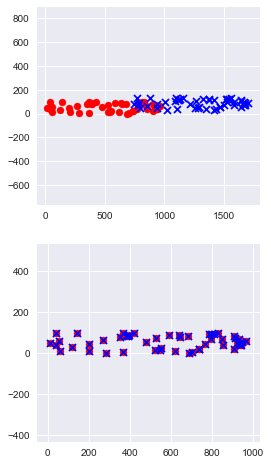

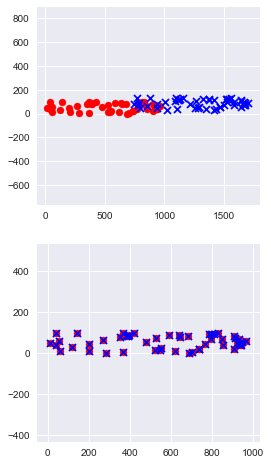

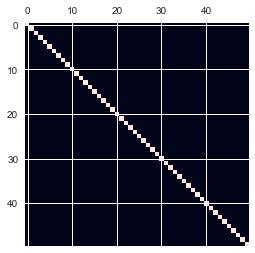

In [9]:
print(reg1.iteration, rmse(ps1, result1[0]), reg1.err)
print(reg2.iteration, rmse(ps1, result2), reg2.Q_old - reg2.Q)
plot_results(ps1, ps2, result1[0])
plot_results(ps1, ps2, result2)
plt.matshow(reg2.p_old)

# Extra points

In [10]:
trans = np.random.rand(1, 2) * 1

realpnts = np.random.rand(50, 2)
ps1 = np.concatenate((realpnts, np.random.rand(np.random.randint(20), 2)), axis=0)
ps2 = np.concatenate((realpnts, np.random.rand(np.random.randint(20), 2)), axis=0) + trans
print(ps1.shape, ps2.shape)

(59, 2) (62, 2)


DEBUG:pyPALM.registration:Normalizing data
DEBUG:pyPALM.registration:tx = [[ 0.52931271  0.49821511]], ty = [[ 1.1191171   1.43474431]]
DEBUG:pyPALM.registration:scale_x = [ 3.31313785  3.24537595], scale_y = [ 3.31313785  3.24537595]
DEBUG:pyPALM.registration:self.init_var = 3.0006090693086107
DEBUG:pyPALM.registration:Variance is 0.716329840729423
DEBUG:pyPALM.registration:Variance is 0.31694867399370125
DEBUG:pyPALM.registration:Q_delta = 61.87077280409004
DEBUG:pyPALM.registration:Variance is 0.15570573897149823
DEBUG:pyPALM.registration:Q_delta = 42.264374734592614
DEBUG:pyPALM.registration:Variance is 0.07449328885366278
DEBUG:pyPALM.registration:Q_delta = 38.88817639335334
DEBUG:pyPALM.registration:Variance is 0.02724197069486457
DEBUG:pyPALM.registration:Q_delta = 42.8216502863626
DEBUG:pyPALM.registration:Variance is 0.002010656119469145
DEBUG:pyPALM.registration:Q_delta = 62.258787587273645
DEBUG:pyPALM.registration:Variance is -0.0022659603185523126
DEBUG:pyPALM.registration

458
7 1.5402424347e-18


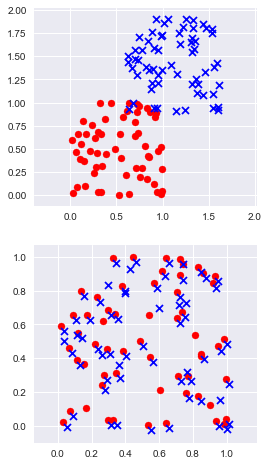

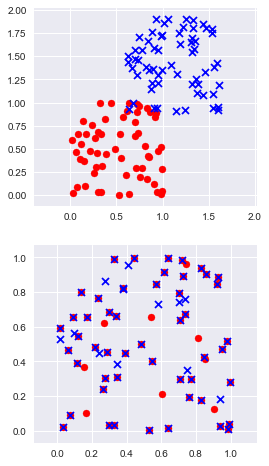

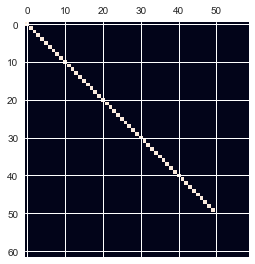

In [11]:
kwargs1 = dict(t=None, sigma2=None, maxIterations=1000, tolerance=1e-6, w=0.2)
kwargs2 = dict(tol=1e-6, maxiters=1000, weight=0.2, init_var=None)
reg1 = translation_registration(ps1, ps2, **kwargs1)
reg2 = myreg.TranslationCPD(ps1, ps2)

with np.errstate(invalid="raise"):
    result1 = reg1.register(None)
    result2 = reg2(**kwargs2)
    print(reg1.iteration)
    print(reg2.iteration, reg2.rmse)

    plot_results(ps1, ps2, result1[0])
    plot_results(ps1, ps2, result2)
plt.matshow(reg2.p_old)

## Jiggled points

In [23]:
nnoise = 10
noise_pnts1, noise_pnts2 = np.random.rand(2, nnoise, 2)
trans = np.random.rand(1, 2) * 1

realpnts = np.random.rand(50, 2)
ps1 = np.concatenate((realpnts + np.random.randn(*realpnts.shape)*0.001, noise_pnts1))
ps2 = np.concatenate((realpnts + np.random.randn(*realpnts.shape)*0.001, noise_pnts2)) + trans

DEBUG:pyPALM.registration:Normalizing data
DEBUG:pyPALM.registration:tx = [[ 0.50032963  0.48831206]], ty = [[ 0.5972188   0.88941375]]
DEBUG:pyPALM.registration:scale_x = [ 3.49718571  3.37582796], scale_y = [ 3.49718571  3.37582796]
DEBUG:pyPALM.registration:self.init_var = 2.999999999999999
DEBUG:pyPALM.registration:Variance is 0.7101836722557078
DEBUG:pyPALM.registration:Variance is 0.3167223920749014
DEBUG:pyPALM.registration:Q_delta = 41.0081223169214
DEBUG:pyPALM.registration:Variance is 0.1614330089419918
DEBUG:pyPALM.registration:Q_delta = 35.86906538005694
DEBUG:pyPALM.registration:Variance is 0.08829769534272888
DEBUG:pyPALM.registration:Q_delta = 33.540133284479914
DEBUG:pyPALM.registration:Variance is 0.04706227522059025
DEBUG:pyPALM.registration:Q_delta = 32.93861542067006
DEBUG:pyPALM.registration:Variance is 0.020155879155594393
DEBUG:pyPALM.registration:Q_delta = 38.267111850623635
DEBUG:pyPALM.registration:Variance is 0.004542097550124351
DEBUG:pyPALM.registration:Q_d

DEBUG:pyPALM.registration:Variance is -8.411573849567094e-05
DEBUG:pyPALM.registration:Q_delta = 0.00598438231787668
DEBUG:pyPALM.registration:Variance is -8.477982095938555e-05
DEBUG:pyPALM.registration:Q_delta = 0.005525615257596428
DEBUG:pyPALM.registration:Variance is -8.55271952151839e-05
DEBUG:pyPALM.registration:Q_delta = 0.0050564286915744105
DEBUG:pyPALM.registration:Variance is -8.633164400321906e-05
DEBUG:pyPALM.registration:Q_delta = 0.004594009171569269
DEBUG:pyPALM.registration:Variance is -8.71712400850619e-05
DEBUG:pyPALM.registration:Q_delta = 0.004150086504239425
DEBUG:pyPALM.registration:Variance is -8.802783999772085e-05
DEBUG:pyPALM.registration:Q_delta = 0.003732150728922079
DEBUG:pyPALM.registration:Variance is -8.888661912619948e-05
DEBUG:pyPALM.registration:Q_delta = 0.0033444848515955528
DEBUG:pyPALM.registration:Variance is -8.97356469774603e-05
DEBUG:pyPALM.registration:Q_delta = 0.002989013500382498
DEBUG:pyPALM.registration:Variance is -9.056550072826636e-

DEBUG:pyPALM.registration:Q_delta = 8.470258779880169e-05
DEBUG:pyPALM.registration:Variance is -0.00010119396338873606
DEBUG:pyPALM.registration:Q_delta = 7.62562361842356e-05
DEBUG:pyPALM.registration:Variance is -0.00010124712063585043
DEBUG:pyPALM.registration:Q_delta = 6.866273017180902e-05
DEBUG:pyPALM.registration:Variance is -0.00010129515891119453
DEBUG:pyPALM.registration:Q_delta = 6.183401825410328e-05
DEBUG:pyPALM.registration:Variance is -0.00010133856186074264
DEBUG:pyPALM.registration:Q_delta = 5.569149638517956e-05
DEBUG:pyPALM.registration:Variance is -0.00010137776917618943
DEBUG:pyPALM.registration:Q_delta = 5.016491721221428e-05
DEBUG:pyPALM.registration:Variance is -0.00010141318026255486
DEBUG:pyPALM.registration:Q_delta = 4.5191457417104175e-05
DEBUG:pyPALM.registration:Variance is -0.00010144515765804889
DEBUG:pyPALM.registration:Q_delta = 4.071490150181489e-05
DEBUG:pyPALM.registration:Variance is -0.00010147403022021355
DEBUG:pyPALM.registration:Q_delta = 3.66

DEBUG:pyPALM.registration:Variance is -0.00010172978410860029
DEBUG:pyPALM.registration:Q_delta = 1.4751113042166253e-06
DEBUG:pyPALM.registration:Variance is -0.00010173085055088869
DEBUG:pyPALM.registration:Q_delta = 1.3301143440003216e-06
DEBUG:pyPALM.registration:Variance is -0.00010173181223583095
DEBUG:pyPALM.registration:Q_delta = 1.1993732016435388e-06
DEBUG:pyPALM.registration:Variance is -0.0001017326794491104
DEBUG:pyPALM.registration:Q_delta = 1.0814834183747735e-06
DEBUG:pyPALM.registration:Variance is -0.00010173346146890651
DEBUG:pyPALM.registration:Q_delta = 9.751854577189079e-07
INFO:pyPALM.registration:Objective function converged, Q_delta = 9.752e-07
DEBUG:pyPALM.registration:Undoing normalization


665
124 4.73887842621e-06


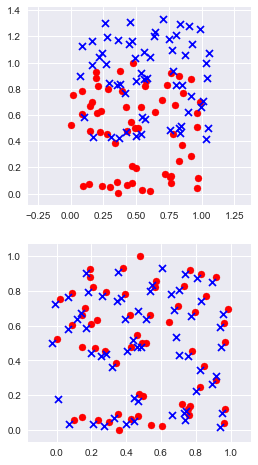

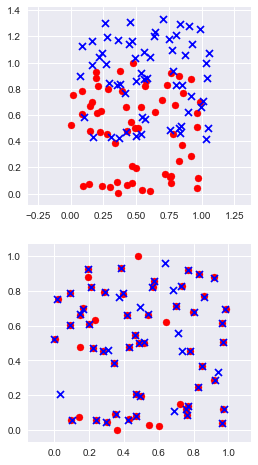

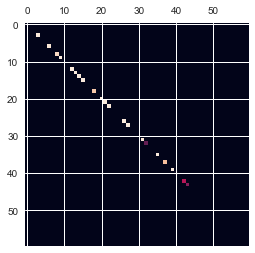

In [25]:
kwargs1 = dict(t=None, sigma2=None, maxIterations=1000, tolerance=1e-6, w=0.5)
kwargs2 = dict(tol=1e-6, maxiters=1000, weight=0.5, init_var=None)
reg1 = translation_registration(ps1, ps2, **kwargs1)
reg2 = myreg.TranslationCPD(ps1, ps2)

with np.errstate(invalid="raise"):
    result1 = reg1.register(None)
    result2 = reg2(**kwargs2)
    print(reg1.iteration)
    print(reg2.iteration, reg2.rmse)

    plot_results(ps1, ps2, result1[0])
    plot_results(ps1, ps2, result2)
plt.matshow(reg2.p_old)

## Affine

In [119]:
nnoise = 40
jiggle = 0.001
dim = 1
noise_pnts1, noise_pnts2 = [np.random.rand(np.random.randint(nnoise//4, nnoise), dim) for i in range(2)]
trans = np.random.rand(1, dim) * 0.01
B = np.random.randn(dim,dim) * 0.01 + np.eye(dim)

realpnts = np.random.rand(20, dim)
ps1 = np.concatenate((realpnts, noise_pnts1))
ps1 += np.random.randn(*ps1.shape)*jiggle
ps2 = np.concatenate((realpnts, noise_pnts2)) @ B.T + trans
ps2 += np.random.randn(*ps2.shape)*jiggle
ps2 = ps2[np.random.rand(ps2.shape[0]).argsort()]
ps1.shape, ps2.shape

((51, 1), (39, 1))

In [120]:
logger.setLevel(logging.WARNING)
ws = np.arange(0, 1, 0.01)
data = []
regs = []
for w in ws:
#     kwargs1 = dict(t=None, sigma2=None, maxIterations=1000, tolerance=1e-6, w=w)
    kwargs2 = dict(tol=1e-10, maxiters=1000, weight=w)
    reg2 = myreg.AffineCPD(ps1, ps2)
#     reg1 = affine_registration(ps1, ps2, **kwargs1)

    with np.errstate(invalid="raise"):
#         result1 = reg1.register(None)
        result2 = reg2(**kwargs2)
#         print(reg1.iteration)
#         print("*"*80)
        d = reg2.rmse, reg2.p_old.sum(), (reg2.p_old**2).sum(), reg2.rmse/(reg2.p_old**2).sum(), ((myreg.la.pinv(reg2.B) - B)**2).sum()
#         print("RSMSE", d[0])
#         print("P sum",d[1])
#         print("P**2 sum", d[2])
#         print("RMSE / P**2 sum", d[3])
#         print("B diff", d[4])
        data.append(d)
        regs.append(reg2)

#         plot_results(ps1, ps2, result1[0])
#         plot_results(ps1, ps2, result2)
#     plt.matshow(reg2.p_old)
#     reg2.plot()
reg2.p_old.shape

(39, 51)

(<matplotlib.figure.Figure at 0x1289e5b00>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11aa7bef0>,))

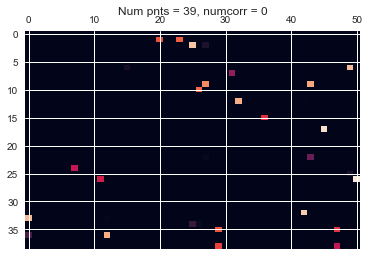

In [125]:
reg2.plot()

In [126]:
data = np.asarray(data)

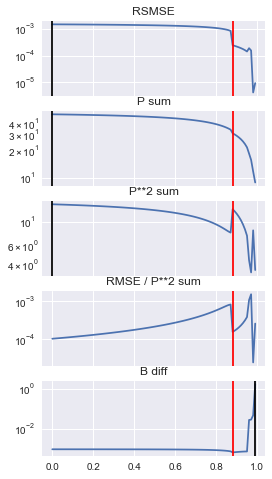

In [127]:
fig, axs = plt.subplots(5, figsize=(4, 8), sharex=True)
for i, (ax, d) in enumerate(zip(axs.ravel(), data.T)):
    if i == 3:
        ax.semilogy(ws, d / (1 - ws))
    else:
        ax.semilogy(ws, d)
        ax.axvline(ws[d.argmax()], c="k")
for ax, t in zip(axs,("RSMSE","P sum","P**2 sum", "RMSE / P**2 sum","B diff")):
    ax.axvline(ws[d.argmin()], c="r")
    ax.set_title(t)

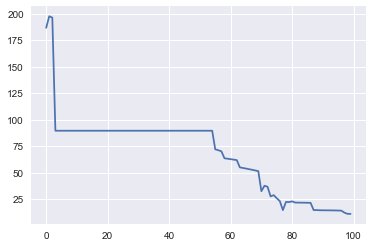

In [128]:
plt.plot(ds[0] * ds[1])

In [110]:
dd = dict()

In [111]:
dd.update(a="a")
dd

{'a': 'a'}

TypeError: unhashable type: 'slice'

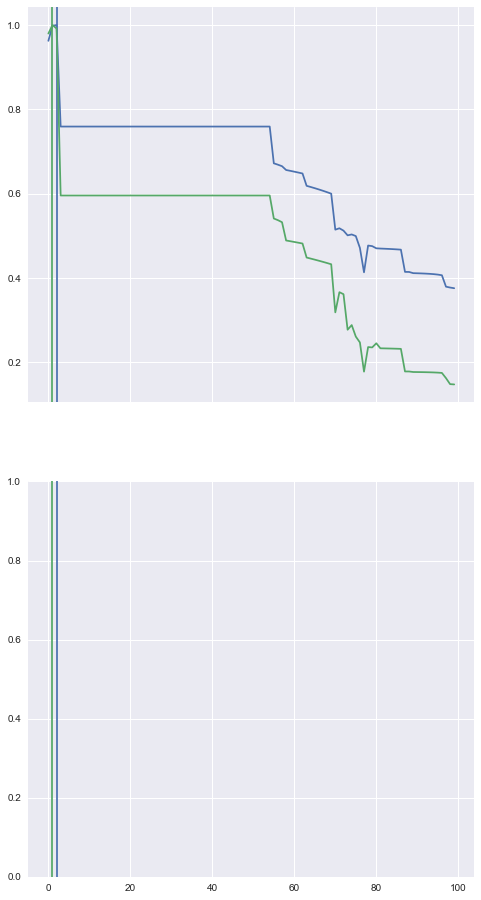

In [96]:
fig, axs = plt.subplots(2, sharex=True, figsize=(8,16))
ds = [np.asarray([np.linalg.norm(reg.p_old, o) for reg in regs]) for o in ("fro", "nuc")]
# ds.append(ds[0] * ds[1])
# ds.append(ds[0] + ds[1])
# ds.append(ds[0] / ds[1])
# ds.append(ds[0] - ds[1])
for d in ds:
    m = d[1:-5].argmax() + 1
    p = axs[0].plot(d/d.max(), label="{}".format(m))
    for ax in axs:
        ax.axvline(m, c=p[0].get_color())
axs[1].semilogy(data[:, -1])
for ax in axs:
    ax.axvline(data[:, -1].argmin(), c="r", label="{}".format(data[:, -1].argmin()))
axs[0].legend()
np.isclose(data[:, -1][m], data[:, -1][data[:, -1].argmin()])

(<matplotlib.figure.Figure at 0x11b029208>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x119b0f6a0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x119c275f8>))

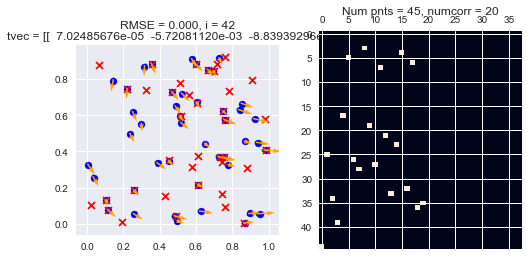

In [31]:
regs[data[:, -1].argmin()].plot(only2d=True)

In [37]:
jiggle = 0.001
tnoise = 0.01
logger.setLevel(logging.WARNING)
# weights
ws = np.arange(0, 1, 0.01)
data = {}
for dim in (2, 3):
    data_dim = data[dim] = {}
    for nnoise in (0, 10, 20, 30, 40):
        data_dim_noise = data_dim[nnoise] = {}
        for iteration in range(100):
            data_dim_noise_i = data_dim_noise[iteration] = {}
            # make noise points
            if nnoise > 0:
                noise_pnts1, noise_pnts2 = [np.random.rand(np.random.randint(nnoise//4, nnoise), dim) for i in range(2)]
            else:
                noise_pnts1, noise_pnts2 = [np.random.rand(0, dim) for i in range(2)]

            # generate affine transform
            trans = np.random.rand(1, dim) * tnoise
            B = np.random.randn(dim,dim) * tnoise + np.eye(dim)
            data_dim_noise_i["transform"] = dict(B=B, trans=trans)
            # make the real data
            realpnts = np.random.rand(20, dim)
            # add the noise points
            ps1 = np.concatenate((realpnts, noise_pnts1))
            ps2 = np.concatenate((realpnts, noise_pnts2)) @ B.T + trans
            # jiggle the points
            ps2 += np.random.randn(*ps2.shape)*jiggle
            # change the sorting
            ps2 = ps2[np.random.rand(ps2.shape[0]).argsort()]
            print(ps1.shape, ps2.shape)


            data_dim_noise_i["regs"] = regs = []
            for w in ws:
                kwargs2 = dict(tol=1e-10, maxiters=1000, weight=w)
                reg2 = myreg.AffineCPD(ps1, ps2)

                with np.errstate(invalid="raise"):
                    try:
                        result2 = reg2(**kwargs2)
                    except Exception as e:
                        print(e)
                    else:
                        regs.append(reg2)

#                 break
#             break
#         break

(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)
(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.020893700181829e-18 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 2) (20, 2)
(20, 2) (20, 2)


(20, 2) (20, 2)
(20, 2) (20, 2)
(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)
(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)
(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)
(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)
(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)
(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)


(20, 2) (20, 2)
(20, 2) (20, 2)


(26, 2) (23, 2)
(22, 2) (28, 2)


(22, 2) (25, 2)


(29, 2) (23, 2)


(28, 2) (25, 2)
(25, 2) (22, 2)
(23, 2) (29, 2)
(27, 2) (26, 2)


(29, 2) (29, 2)


(23, 2) (25, 2)


(26, 2) (22, 2)


(23, 2) (26, 2)


(26, 2) (27, 2)


(23, 2) (29, 2)
(24, 2) (27, 2)


(27, 2) (28, 2)
(29, 2) (26, 2)
(28, 2) (26, 2)


(25, 2) (29, 2)


(24, 2) (24, 2)


(28, 2) (29, 2)


(28, 2) (23, 2)


(26, 2) (24, 2)


(26, 2) (27, 2)


(26, 2) (25, 2)


(28, 2) (22, 2)


(26, 2) (28, 2)


(28, 2) (27, 2)


(26, 2) (23, 2)


(29, 2) (26, 2)


(23, 2) (24, 2)


(24, 2) (22, 2)


(26, 2) (24, 2)


(23, 2) (23, 2)


(25, 2) (26, 2)


(29, 2) (24, 2)
(23, 2) (29, 2)


(23, 2) (22, 2)


(25, 2) (23, 2)


(26, 2) (27, 2)


(22, 2) (22, 2)


(24, 2) (26, 2)


(22, 2) (22, 2)


Matrix is singular.
(26, 2) (29, 2)


(27, 2) (23, 2)


(24, 2) (29, 2)


(22, 2) (23, 2)


(26, 2) (27, 2)


(26, 2) (23, 2)


(25, 2) (25, 2)


(24, 2) (29, 2)


(26, 2) (25, 2)


(23, 2) (22, 2)


(25, 2) (22, 2)


(23, 2) (28, 2)


(29, 2) (25, 2)


(22, 2) (28, 2)


(26, 2) (23, 2)


(28, 2) (24, 2)
(29, 2) (25, 2)


(28, 2) (23, 2)


(22, 2) (22, 2)


(24, 2) (22, 2)


(25, 2) (22, 2)


(23, 2) (26, 2)


(22, 2) (23, 2)


(26, 2) (26, 2)


(24, 2) (26, 2)


(29, 2) (23, 2)


(25, 2) (23, 2)


(23, 2) (28, 2)


(23, 2) (22, 2)


(22, 2) (24, 2)


(24, 2) (26, 2)


(23, 2) (22, 2)


(29, 2) (24, 2)


(27, 2) (23, 2)


(22, 2) (29, 2)


(28, 2) (28, 2)


(25, 2) (28, 2)


(22, 2) (27, 2)


(26, 2) (25, 2)


(23, 2) (24, 2)


(24, 2) (24, 2)


(28, 2) (23, 2)
(28, 2) (26, 2)


(25, 2) (29, 2)


(23, 2) (24, 2)
(22, 2) (25, 2)
(28, 2) (28, 2)
(22, 2) (28, 2)


(29, 2) (22, 2)


(27, 2) (27, 2)


(22, 2) (28, 2)


(28, 2) (23, 2)


(23, 2) (22, 2)


(28, 2) (27, 2)


(27, 2) (25, 2)


(24, 2) (23, 2)
(22, 2) (24, 2)


(25, 2) (33, 2)


(35, 2) (37, 2)
(35, 2) (29, 2)


(38, 2) (37, 2)


(32, 2) (38, 2)
(31, 2) (39, 2)


(33, 2) (36, 2)


(31, 2) (36, 2)
(31, 2) (34, 2)


(38, 2) (35, 2)
(32, 2) (31, 2)
(25, 2) (30, 2)


(25, 2) (37, 2)


(32, 2) (33, 2)
(36, 2) (34, 2)
(33, 2) (28, 2)
(27, 2) (35, 2)


(26, 2) (36, 2)


(28, 2) (39, 2)


(36, 2) (35, 2)
(25, 2) (38, 2)


(31, 2) (30, 2)


(30, 2) (36, 2)


(38, 2) (38, 2)


(25, 2) (37, 2)
(31, 2) (29, 2)


(34, 2) (30, 2)


(32, 2) (33, 2)


(38, 2) (26, 2)


(38, 2) (36, 2)


(27, 2) (33, 2)


(35, 2) (26, 2)


(37, 2) (32, 2)
(33, 2) (25, 2)


(29, 2) (33, 2)


(39, 2) (30, 2)


(34, 2) (39, 2)


(28, 2) (36, 2)
(34, 2) (31, 2)
(33, 2) (25, 2)


(39, 2) (33, 2)
(27, 2) (36, 2)


(31, 2) (25, 2)


(26, 2) (25, 2)


(26, 2) (29, 2)


(27, 2) (34, 2)


(25, 2) (30, 2)


(36, 2) (32, 2)
(28, 2) (36, 2)


(34, 2) (34, 2)


(25, 2) (29, 2)
(32, 2) (34, 2)
(37, 2) (30, 2)


(38, 2) (33, 2)


(38, 2) (27, 2)


(35, 2) (26, 2)
(25, 2) (27, 2)


(28, 2) (29, 2)
(39, 2) (34, 2)


(25, 2) (31, 2)


(39, 2) (27, 2)


(34, 2) (33, 2)
(35, 2) (34, 2)


(28, 2) (28, 2)


(32, 2) (29, 2)
(36, 2) (34, 2)
(36, 2) (37, 2)


(35, 2) (26, 2)


(25, 2) (38, 2)


(29, 2) (28, 2)


(31, 2) (27, 2)
(39, 2) (39, 2)


(36, 2) (30, 2)
(29, 2) (25, 2)


(37, 2) (38, 2)


(27, 2) (25, 2)


(33, 2) (27, 2)


(34, 2) (39, 2)


(28, 2) (28, 2)


(27, 2) (34, 2)


(26, 2) (31, 2)


(31, 2) (39, 2)


(26, 2) (26, 2)


(39, 2) (31, 2)
(39, 2) (38, 2)


(38, 2) (26, 2)


(38, 2) (36, 2)


(27, 2) (35, 2)


(27, 2) (26, 2)


(33, 2) (25, 2)
(29, 2) (34, 2)


(37, 2) (34, 2)


(28, 2) (36, 2)


(31, 2) (32, 2)


(35, 2) (33, 2)


(39, 2) (28, 2)


(31, 2) (32, 2)


(29, 2) (26, 2)
(30, 2) (38, 2)


(26, 2) (30, 2)
(28, 2) (36, 2)
(38, 2) (44, 2)
(38, 2) (34, 2)


(32, 2) (46, 2)


(38, 2) (31, 2)


(38, 2) (44, 2)
(39, 2) (29, 2)


(47, 2) (32, 2)


(43, 2) (45, 2)
(40, 2) (30, 2)
(35, 2) (46, 2)
(36, 2) (46, 2)
(31, 2) (45, 2)


(28, 2) (47, 2)


(49, 2) (31, 2)


(38, 2) (27, 2)
(36, 2) (27, 2)


(34, 2) (47, 2)


(37, 2) (31, 2)


(32, 2) (32, 2)
(40, 2) (30, 2)
(35, 2) (32, 2)


(43, 2) (43, 2)
(49, 2) (31, 2)


(27, 2) (38, 2)


(38, 2) (27, 2)


(45, 2) (43, 2)
(40, 2) (28, 2)
(48, 2) (42, 2)


(28, 2) (45, 2)


(36, 2) (42, 2)
(30, 2) (29, 2)


(34, 2) (39, 2)


(28, 2) (28, 2)


(36, 2) (29, 2)
(32, 2) (48, 2)


(30, 2) (28, 2)


(42, 2) (44, 2)
(34, 2) (45, 2)


(45, 2) (35, 2)
(31, 2) (33, 2)


(46, 2) (45, 2)


(42, 2) (35, 2)


(43, 2) (33, 2)


(29, 2) (46, 2)


(47, 2) (31, 2)
(28, 2) (43, 2)


(40, 2) (42, 2)


(33, 2) (44, 2)


(32, 2) (49, 2)


(43, 2) (48, 2)


(48, 2) (42, 2)


(40, 2) (39, 2)
(38, 2) (32, 2)
(41, 2) (44, 2)
(46, 2) (27, 2)


(31, 2) (47, 2)


(42, 2) (35, 2)


(38, 2) (36, 2)
(39, 2) (37, 2)
(34, 2) (31, 2)
(38, 2) (45, 2)
(39, 2) (30, 2)
(45, 2) (45, 2)


(31, 2) (35, 2)


(49, 2) (29, 2)
(33, 2) (43, 2)


(28, 2) (28, 2)


(43, 2) (46, 2)
(47, 2) (37, 2)
(41, 2) (47, 2)


(40, 2) (38, 2)


(40, 2) (32, 2)


(41, 2) (39, 2)
(31, 2) (38, 2)


(27, 2) (27, 2)


(44, 2) (40, 2)


(48, 2) (46, 2)
(32, 2) (36, 2)


(31, 2) (41, 2)


(47, 2) (28, 2)


(41, 2) (44, 2)
(31, 2) (48, 2)


(32, 2) (37, 2)


(34, 2) (34, 2)


(29, 2) (46, 2)


(30, 2) (40, 2)
(47, 2) (32, 2)


(35, 2) (39, 2)


(27, 2) (42, 2)


(37, 2) (30, 2)
(37, 2) (37, 2)
(37, 2) (32, 2)


(40, 2) (35, 2)
(42, 2) (30, 2)


(30, 2) (44, 2)


(42, 2) (35, 2)


(33, 2) (47, 2)


(39, 2) (37, 2)


(47, 2) (35, 2)


(46, 2) (52, 2)
(54, 2) (47, 2)


(47, 2) (51, 2)
(52, 2) (50, 2)


(54, 2) (36, 2)


(47, 2) (34, 2)
(49, 2) (31, 2)


(40, 2) (45, 2)


(30, 2) (36, 2)


(43, 2) (51, 2)


(34, 2) (36, 2)


(54, 2) (39, 2)
(49, 2) (52, 2)


(57, 2) (44, 2)


(43, 2) (40, 2)


(56, 2) (37, 2)


(57, 2) (51, 2)


(51, 2) (42, 2)


(53, 2) (36, 2)
(58, 2) (40, 2)


(54, 2) (43, 2)
(44, 2) (43, 2)
(55, 2) (43, 2)


(49, 2) (45, 2)


(30, 2) (55, 2)
(42, 2) (53, 2)
(56, 2) (56, 2)
(32, 2) (36, 2)
(52, 2) (34, 2)


(35, 2) (51, 2)


(46, 2) (48, 2)
(48, 2) (59, 2)
(46, 2) (39, 2)
(43, 2) (57, 2)
(46, 2) (44, 2)


(49, 2) (37, 2)
(44, 2) (48, 2)
(37, 2) (55, 2)


(45, 2) (40, 2)


(40, 2) (40, 2)
(40, 2) (59, 2)


(43, 2) (33, 2)


(38, 2) (55, 2)
(47, 2) (39, 2)


(53, 2) (51, 2)


(49, 2) (48, 2)


(39, 2) (52, 2)


(51, 2) (39, 2)


(33, 2) (55, 2)
(46, 2) (47, 2)


(42, 2) (40, 2)


(50, 2) (48, 2)
(40, 2) (47, 2)
(37, 2) (47, 2)


(37, 2) (44, 2)
(33, 2) (39, 2)


(35, 2) (58, 2)


(41, 2) (43, 2)


(45, 2) (34, 2)


(51, 2) (59, 2)
(55, 2) (54, 2)


(50, 2) (38, 2)


(39, 2) (54, 2)
(36, 2) (48, 2)
(52, 2) (58, 2)
(35, 2) (43, 2)


(59, 2) (47, 2)
(53, 2) (48, 2)
(52, 2) (34, 2)
(49, 2) (54, 2)
(58, 2) (39, 2)
(59, 2) (47, 2)
(59, 2) (50, 2)


(43, 2) (39, 2)
(38, 2) (36, 2)
(48, 2) (56, 2)


(30, 2) (38, 2)


(37, 2) (35, 2)
(48, 2) (54, 2)
(58, 2) (53, 2)


(59, 2) (42, 2)
(49, 2) (43, 2)
(31, 2) (49, 2)


(32, 2) (41, 2)


(32, 2) (39, 2)
(42, 2) (39, 2)


(48, 2) (49, 2)
(48, 2) (56, 2)
(52, 2) (54, 2)
(35, 2) (55, 2)


(33, 2) (58, 2)


(35, 2) (51, 2)
(57, 2) (45, 2)
(33, 2) (58, 2)


(36, 2) (50, 2)


(55, 2) (49, 2)


(54, 2) (59, 2)


(42, 2) (31, 2)


(49, 2) (52, 2)
(48, 2) (49, 2)
(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.4879010563037985e-18 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.0866568279641553e-18 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 3) (20, 3)


(20, 3) (20, 3)


Matrix is singular.
(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.2707558379609446e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.7751306870156084e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 3) (20, 3)


(20, 3) (20, 3)


Matrix is singular.
(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


Matrix is singular.
(20, 3) (20, 3)


(20, 3) (20, 3)
(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.463252271447338e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.4181085034209e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 3) (20, 3)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.795823828033538e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.291723858978586e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.108141945879264e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 3) (20, 3)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.5570370735819698e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 3) (20, 3)


(20, 3) (20, 3)


Matrix is singular.
(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


Matrix is singular.
(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6954358809843186e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.0750491933949424e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.0750491890866442e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.0750491958329253e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned

(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


Matrix is singular.
(20, 3) (20, 3)


(20, 3) (20, 3)


Matrix is singular.
(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2250120427407606e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


Matrix is singular.
(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


Matrix is singular.
(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6840659903798975e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.115124636110823e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 3) (20, 3)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4249294780269196e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Matrix is singular.
(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6933328493071683e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Matrix is singular.
Matrix is singular.
(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1294878481401122e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.2588558821986003e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.933280757782459e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Matrix is singular.
Matrix is singular.
(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.399755590151259e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Matrix is singular.
(20, 3) (20, 3)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.929154718071391e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.910960393360782e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.78576477191326e-18 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 3) (20, 3)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.7047692952100946e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.507948357615941e-19 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.015896858533713e-19 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.576727676935572e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)


(20, 3) (20, 3)
(20, 3) (20, 3)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.30188609321079e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(20, 3) (20, 3)


(20, 3) (20, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0091421880933038e-16 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.364317479102571e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(26, 3) (29, 3)


(25, 3) (23, 3)


(27, 3) (29, 3)


(27, 3) (25, 3)


(25, 3) (29, 3)


(26, 3) (22, 3)


(22, 3) (27, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2831385055504471e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(22, 3) (29, 3)


(25, 3) (25, 3)


(25, 3) (23, 3)


(23, 3) (27, 3)


(25, 3) (26, 3)


(23, 3) (27, 3)


(26, 3) (22, 3)


(24, 3) (22, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.2406492490989176e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Matrix is singular.
(28, 3) (27, 3)


(25, 3) (22, 3)


(27, 3) (24, 3)


(23, 3) (29, 3)


(28, 3) (28, 3)


(28, 3) (23, 3)


(27, 3) (27, 3)


(24, 3) (24, 3)


(25, 3) (24, 3)


(24, 3) (25, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.4812232753539348e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(28, 3) (23, 3)


(29, 3) (25, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.135289902613374e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Matrix is singular.
Matrix is singular.
(27, 3) (26, 3)


(29, 3) (24, 3)


(29, 3) (28, 3)


(24, 3) (25, 3)


(29, 3) (25, 3)


(29, 3) (29, 3)


(27, 3) (29, 3)


(23, 3) (23, 3)


(26, 3) (22, 3)


Matrix is singular.
(23, 3) (28, 3)


(27, 3) (22, 3)


(25, 3) (27, 3)


Matrix is singular.
(27, 3) (22, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.1607879871455984e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(29, 3) (28, 3)


(24, 3) (29, 3)


(28, 3) (27, 3)


(26, 3) (23, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.549076823727615e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.098153645366673e-18 / 1.1102230246251565e-16
  RuntimeWarning)


(24, 3) (26, 3)


(29, 3) (22, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.067439797844083e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(23, 3) (25, 3)


(29, 3) (28, 3)


(28, 3) (25, 3)


(25, 3) (22, 3)


(24, 3) (23, 3)


(23, 3) (24, 3)


(29, 3) (27, 3)


Matrix is singular.
(29, 3) (28, 3)


(23, 3) (27, 3)


(25, 3) (26, 3)


(23, 3) (23, 3)


(22, 3) (22, 3)


(28, 3) (22, 3)


(27, 3) (26, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.256722017171668e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(22, 3) (26, 3)


(23, 3) (26, 3)


(29, 3) (26, 3)


(22, 3) (24, 3)


(26, 3) (28, 3)


(28, 3) (22, 3)


(23, 3) (29, 3)


(28, 3) (24, 3)


(28, 3) (23, 3)


(24, 3) (27, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.255648277344296e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(24, 3) (22, 3)


(29, 3) (27, 3)


(28, 3) (28, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.3904577662993225e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Matrix is singular.
(28, 3) (23, 3)


(29, 3) (24, 3)


(24, 3) (25, 3)


(23, 3) (27, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.94859904049706e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(27, 3) (25, 3)


(27, 3) (24, 3)


Matrix is singular.
(29, 3) (29, 3)


(22, 3) (28, 3)


(25, 3) (24, 3)


(27, 3) (22, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.682934715326135e-18 / 1.1102230246251565e-16
  RuntimeWarning)


(29, 3) (25, 3)


(26, 3) (23, 3)


(22, 3) (24, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6258929602722668e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(25, 3) (27, 3)


(24, 3) (29, 3)


(28, 3) (26, 3)


(24, 3) (27, 3)


Matrix is singular.
(24, 3) (29, 3)


(28, 3) (23, 3)


(27, 3) (25, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.189592859933181e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(22, 3) (29, 3)


(25, 3) (22, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.229601766902845e-18 / 1.1102230246251565e-16
  RuntimeWarning)


(24, 3) (29, 3)


(23, 3) (22, 3)


Matrix is singular.
(29, 3) (28, 3)


(27, 3) (23, 3)


(22, 3) (24, 3)


(35, 3) (25, 3)


(25, 3) (39, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.2004673882054115e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.1002331943398593e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(35, 3) (30, 3)


(33, 3) (27, 3)


(37, 3) (30, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.5370324493901082e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(27, 3) (37, 3)


(34, 3) (30, 3)


(29, 3) (36, 3)


(32, 3) (38, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0550242675639572e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(29, 3) (32, 3)


(32, 3) (30, 3)


(28, 3) (25, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.3553379645644504e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0403962703651148e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Matrix is singular.
(31, 3) (27, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.4478623408431847e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(34, 3) (29, 3)


(35, 3) (27, 3)


(28, 3) (28, 3)


(27, 3) (34, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.045319710108533e-18 / 1.1102230246251565e-16
  RuntimeWarning)


(32, 3) (35, 3)


(25, 3) (28, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.0598799507672493e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(36, 3) (33, 3)


(30, 3) (39, 3)


(27, 3) (39, 3)


(29, 3) (29, 3)


(32, 3) (36, 3)


(25, 3) (26, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.024819733653345e-18 / 1.1102230246251565e-16
  RuntimeWarning)


(27, 3) (32, 3)


(39, 3) (34, 3)


(33, 3) (32, 3)


(38, 3) (28, 3)


(39, 3) (35, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.442828322284853e-19 / 1.1102230246251565e-16
  RuntimeWarning)


(37, 3) (33, 3)


(25, 3) (33, 3)


(25, 3) (38, 3)


(31, 3) (32, 3)


Matrix is singular.
(39, 3) (26, 3)


(32, 3) (34, 3)


(35, 3) (31, 3)


(26, 3) (37, 3)


(35, 3) (30, 3)


(35, 3) (37, 3)


(36, 3) (37, 3)


(36, 3) (31, 3)


(37, 3) (27, 3)


(31, 3) (31, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.015154039087857e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6717133335937196e-18 / 1.1102230246251565e-16
  RuntimeWarning)


(34, 3) (36, 3)


(29, 3) (37, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.3759302724943892e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(35, 3) (36, 3)


(28, 3) (29, 3)


(26, 3) (31, 3)


(25, 3) (35, 3)
(37, 3) (38, 3)


(26, 3) (31, 3)


(34, 3) (26, 3)


(28, 3) (32, 3)


(30, 3) (31, 3)


(29, 3) (32, 3)


Matrix is singular.
(29, 3) (33, 3)


(35, 3) (39, 3)


(39, 3) (31, 3)


(39, 3) (37, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1856005982420397e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(36, 3) (32, 3)


(32, 3) (38, 3)


(26, 3) (38, 3)


(29, 3) (36, 3)


(36, 3) (29, 3)


(37, 3) (28, 3)


(26, 3) (38, 3)


(36, 3) (33, 3)


(30, 3) (35, 3)


(37, 3) (37, 3)


(28, 3) (28, 3)


(30, 3) (26, 3)


(39, 3) (33, 3)


(36, 3) (32, 3)


(37, 3) (31, 3)


(29, 3) (25, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.702907148725121e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.702906897912846e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Matrix is singular.
(34, 3) (39, 3)


(26, 3) (25, 3)


(32, 3) (28, 3)


(25, 3) (30, 3)


(36, 3) (25, 3)


(27, 3) (30, 3)


(25, 3) (27, 3)


(35, 3) (37, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.933586141902693e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(25, 3) (26, 3)


(37, 3) (29, 3)


(39, 3) (34, 3)


(26, 3) (39, 3)


(28, 3) (31, 3)


(33, 3) (34, 3)


(28, 3) (32, 3)


(34, 3) (28, 3)


(29, 3) (38, 3)


(27, 3) (29, 3)


(28, 3) (35, 3)


(37, 3) (25, 3)


(32, 3) (38, 3)


(27, 3) (30, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.5523207465883617e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(32, 3) (27, 3)


(31, 3) (35, 3)


(31, 3) (36, 3)


(47, 3) (41, 3)
(47, 3) (47, 3)


(29, 3) (42, 3)


(37, 3) (35, 3)


(34, 3) (31, 3)


(36, 3) (49, 3)


(31, 3) (48, 3)


(30, 3) (44, 3)


(38, 3) (47, 3)


(33, 3) (49, 3)


(46, 3) (42, 3)


(32, 3) (49, 3)


(34, 3) (27, 3)


(34, 3) (28, 3)


(28, 3) (35, 3)


(32, 3) (29, 3)


(46, 3) (27, 3)


(43, 3) (35, 3)


(39, 3) (48, 3)


(36, 3) (43, 3)


(38, 3) (31, 3)


(32, 3) (37, 3)


(34, 3) (31, 3)


(28, 3) (37, 3)


(30, 3) (36, 3)


(39, 3) (44, 3)


(49, 3) (38, 3)


(40, 3) (30, 3)


(37, 3) (37, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.209648585838657e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(39, 3) (49, 3)


(30, 3) (39, 3)


(36, 3) (46, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4976304668006913e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(36, 3) (40, 3)


(45, 3) (37, 3)


(34, 3) (37, 3)


(40, 3) (41, 3)


(37, 3) (33, 3)


(49, 3) (40, 3)


(40, 3) (29, 3)


(47, 3) (38, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.71488010068496e-18 / 1.1102230246251565e-16
  RuntimeWarning)


(30, 3) (36, 3)


(28, 3) (48, 3)


(42, 3) (47, 3)


(48, 3) (39, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.135539273332172e-18 / 1.1102230246251565e-16
  RuntimeWarning)


(41, 3) (34, 3)


(38, 3) (49, 3)


(39, 3) (36, 3)


(40, 3) (44, 3)


(34, 3) (48, 3)


(36, 3) (40, 3)


(49, 3) (43, 3)


(40, 3) (44, 3)


(34, 3) (40, 3)


(46, 3) (37, 3)


(45, 3) (47, 3)
(38, 3) (43, 3)


(46, 3) (29, 3)


(47, 3) (31, 3)


(43, 3) (36, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.937389549759609e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.104101186577547e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(40, 3) (48, 3)


(35, 3) (30, 3)


(47, 3) (44, 3)


(32, 3) (43, 3)


(49, 3) (44, 3)


(32, 3) (45, 3)


(47, 3) (27, 3)


(42, 3) (34, 3)


(41, 3) (45, 3)


Matrix is singular.
(40, 3) (32, 3)


(37, 3) (33, 3)


(40, 3) (29, 3)


(28, 3) (41, 3)


Matrix is singular.
(35, 3) (35, 3)


(48, 3) (31, 3)


(48, 3) (40, 3)


(42, 3) (35, 3)


(44, 3) (39, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.967707610779805e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.7472794098242965e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(28, 3) (27, 3)


(49, 3) (44, 3)


(40, 3) (45, 3)


(28, 3) (34, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.755129182307568e-18 / 1.1102230246251565e-16
  RuntimeWarning)


(27, 3) (47, 3)


(45, 3) (48, 3)


(29, 3) (41, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4945672517716116e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.494853970426264e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(39, 3) (31, 3)


(36, 3) (39, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.025871385964995e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(45, 3) (31, 3)


(46, 3) (46, 3)


(34, 3) (35, 3)


(49, 3) (49, 3)


(49, 3) (31, 3)


(48, 3) (28, 3)


(39, 3) (32, 3)


(47, 3) (48, 3)


(45, 3) (30, 3)


(35, 3) (32, 3)


(34, 3) (31, 3)


(49, 3) (30, 3)


(27, 3) (28, 3)


(46, 3) (41, 3)


(32, 3) (40, 3)


(44, 3) (53, 3)


(56, 3) (43, 3)


(34, 3) (59, 3)


(53, 3) (36, 3)


(42, 3) (41, 3)


(50, 3) (35, 3)


(38, 3) (38, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.692796185937108e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.823816102350765e-18 / 1.1102230246251565e-16
  RuntimeWarning)


(54, 3) (34, 3)


(36, 3) (36, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6370560089158712e-18 / 1.1102230246251565e-16
  RuntimeWarning)


(55, 3) (58, 3)


(59, 3) (59, 3)


(38, 3) (32, 3)


(51, 3) (55, 3)


(36, 3) (46, 3)


(52, 3) (57, 3)


Matrix is singular.
(50, 3) (37, 3)


(58, 3) (40, 3)


(59, 3) (38, 3)


(56, 3) (53, 3)
(37, 3) (34, 3)


(58, 3) (30, 3)
(40, 3) (40, 3)


(37, 3) (59, 3)


(57, 3) (44, 3)


(58, 3) (35, 3)


(59, 3) (45, 3)


(57, 3) (44, 3)


(31, 3) (46, 3)


(56, 3) (56, 3)


(49, 3) (56, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.042025664668139e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.2252153988084104e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(57, 3) (33, 3)


(48, 3) (35, 3)
(59, 3) (38, 3)


(31, 3) (55, 3)


Matrix is singular.
(41, 3) (32, 3)


(47, 3) (52, 3)


(54, 3) (57, 3)


(52, 3) (45, 3)


(59, 3) (44, 3)
(33, 3) (36, 3)


(36, 3) (46, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.506122543373369e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(30, 3) (52, 3)


(45, 3) (59, 3)


(34, 3) (57, 3)


(58, 3) (49, 3)


(46, 3) (38, 3)


(59, 3) (58, 3)


(34, 3) (45, 3)


(36, 3) (46, 3)


(58, 3) (53, 3)


(40, 3) (38, 3)


(42, 3) (40, 3)


(41, 3) (36, 3)


(49, 3) (55, 3)


(52, 3) (44, 3)


(35, 3) (53, 3)


(55, 3) (58, 3)


(55, 3) (43, 3)


(56, 3) (40, 3)


(35, 3) (56, 3)


(49, 3) (58, 3)


(49, 3) (44, 3)


(50, 3) (35, 3)


(47, 3) (52, 3)


(56, 3) (48, 3)


(36, 3) (31, 3)


(52, 3) (49, 3)


(43, 3) (52, 3)


(58, 3) (50, 3)


(46, 3) (43, 3)


(45, 3) (31, 3)


(58, 3) (37, 3)


(42, 3) (56, 3)


(37, 3) (41, 3)


(41, 3) (48, 3)


(49, 3) (30, 3)


(48, 3) (58, 3)


(31, 3) (49, 3)


(33, 3) (50, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.62895957752969e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.628957436806313e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.8868723104180643e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned ma

(36, 3) (30, 3)


(49, 3) (39, 3)


(56, 3) (46, 3)


(40, 3) (47, 3)


(32, 3) (58, 3)


(40, 3) (52, 3)


(45, 3) (38, 3)


(55, 3) (58, 3)


(55, 3) (38, 3)


(57, 3) (55, 3)


/Users/david/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.304274718103305e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(51, 3) (43, 3)


(57, 3) (34, 3)
(40, 3) (51, 3)


Matrix is singular.
(51, 3) (50, 3)


(33, 3) (35, 3)


Matrix is singular.
(48, 3) (30, 3)


(33, 3) (58, 3)


(43, 3) (36, 3)


(49, 3) (46, 3)


In [105]:
for dim, data_dim in data.items():
    for nnoise, data_dim_noise in data_dim.items():
        for iteration, data_dim_noise_i in data_dim_noise.items():
            regs = data_dim_noise_i["regs"]
            t = data_dim_noise_i["transform"]["trans"]
            B = data_dim_noise_i["transform"]["B"]
            data_dim_noise_i["residual_transform"] = np.array([((myreg.la.pinv(reg.B) - B)**2).sum() + ((reg.translation - t)**2).sum() for reg in regs])
            for k in ("fro", "nuc", 1, np.inf):
                data_dim_noise_i[k] = np.asarray([np.linalg.norm(reg.p_old, k) for reg in regs])
            
            data_dim_noise_i["test1"] = np.asarray([np.max(reg.p_old, 0).sum() for reg in regs])
            data_dim_noise_i["test2"] = np.asarray([np.max(reg.p_old, 1).sum() for reg in regs])

In [101]:
def match(residual, metric, crop=5):
    m = metric[crop:-crop].argmax() + crop
    return np.isclose(residual.min(), residual[m])

In [106]:
matches = {}
for dim, data_dim in data.items():
    matches_dim = matches[dim] = {}
    for nnoise, data_dim_noise in data_dim.items():
        matches_dim_noise = matches_dim[nnoise] = {k:list() for k in ("fro", "nuc", 1, np.inf, "test1","test2")}
        for iteration, data_dim_noise_i in data_dim_noise.items():
            residual = data_dim_noise_i["residual_transform"]
            for k in ("fro", "nuc", 1, np.inf, "test1","test2"):
                matches_dim_noise[k].append(match(residual, data_dim_noise_i[k]))

In [107]:
for dim, matches_dim in matches.items():
    print("Dimension", dim)
    for nnoise, matches_dim_noise in matches_dim.items():
        print("Noise", nnoise)
        for k, v in matches_dim_noise.items():
            v = np.asarray(v)
            print("Matrix norm", k, "fraction success", v.mean())

Dimension 2
Noise 0
Matrix norm fro fraction success 0.81
Matrix norm nuc fraction success 0.8
Matrix norm 1 fraction success 0.57
Matrix norm inf fraction success 0.1
Matrix norm test1 fraction success 0.81
Matrix norm test2 fraction success 0.81
Noise 10
Matrix norm fro fraction success 0.78
Matrix norm nuc fraction success 0.77
Matrix norm 1 fraction success 0.72
Matrix norm inf fraction success 0.11
Matrix norm test1 fraction success 0.78
Matrix norm test2 fraction success 0.79
Noise 20
Matrix norm fro fraction success 0.43
Matrix norm nuc fraction success 0.41
Matrix norm 1 fraction success 0.71
Matrix norm inf fraction success 0.04
Matrix norm test1 fraction success 0.37
Matrix norm test2 fraction success 0.53
Noise 30
Matrix norm fro fraction success 0.27
Matrix norm nuc fraction success 0.21
Matrix norm 1 fraction success 0.7
Matrix norm inf fraction success 0.04
Matrix norm test1 fraction success 0.21
Matrix norm test2 fraction success 0.27
Noise 40
Matrix norm fro fraction su

# Time for 3D and slabs

In [14]:
def main2(X, slabs, model=myreg.TranslationCPD, **kwargs):
    
    default_kwargs = dict(tol=1e-6, maxiters=1000, weight=0., init_var=None)
    default_kwargs.update(kwargs)
    
    results = []
    for Y in slabs:
        reg = model(X.T, Y.T)
        result = reg(**default_kwargs)
        results.append(reg)
    
    if len(X) == 3:
        projection = "3d"
    else:
        projection = None
    fig = plt.figure(figsize=(4,8))
    ax0 = fig.add_subplot(211, projection=projection)
    ax1 = fig.add_subplot(212, projection=projection)
    
    ax0.scatter(*X, color='k')
    ax1.scatter(*X, color='k')
    for ax in (ax0, ax1):
        ax.set_prop_cycle(plt.cycler('color', ['c', 'm', 'y', 'r', 'g', 'b']))
    for Y, result in zip(slabs, results):
        ax0.scatter(*Y, marker="x")
        ax1.scatter(*result.TY.T, marker="x")
#     ax0.set_aspect('equal', 'datalim')
#     ax1.set_aspect('equal', 'datalim')
    
    return results

In [15]:
npnts = 50
nnoise = 0
nslabs = 10
noise_pnts1, noise_pnts2 = np.random.rand(2, 3, nnoise)

realpnts = np.random.rand(3, npnts)
ps1 = np.concatenate((realpnts, noise_pnts1), axis=1)
ps2 = np.concatenate((realpnts, noise_pnts2), axis=1)

scale = np.array((18 * 0.2, 512 * 0.13, 512 * 0.13))[:, None]
scale = (1,)
ps1 = ps1 * scale
ps2 = ps2 * scale
ps2 += np.random.randn(*ps2.shape) * 1e-6

slab_limits = np.linspace(0, scale[0], nslabs + 1)
# These are aligned slabs
slabs = [ps2[:, (slab_limits[i] < ps2[0]) & (ps2[0] < slab_limits[i + 1])] for i in range(nslabs)]
slabs_wnoise = [slab + np.random.randn(3, 1) * scale * 0.01 for slab in slabs]
[slab.shape[-1] for slab in slabs_wnoise]

[4, 4, 3, 4, 8, 7, 4, 3, 5, 8]

INFO:pyPALM.registration:Objective function converged
INFO:pyPALM.registration:Objective function converged
INFO:pyPALM.registration:Objective function converged
INFO:pyPALM.registration:Objective function converged
INFO:pyPALM.registration:Objective function converged
INFO:pyPALM.registration:Objective function converged
INFO:pyPALM.registration:Objective function converged
INFO:pyPALM.registration:Objective function converged
INFO:pyPALM.registration:Objective function converged


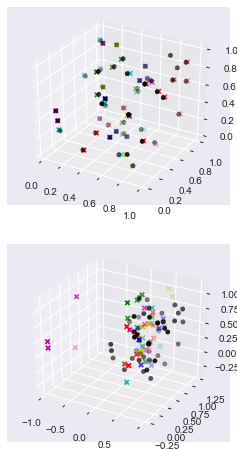

In [16]:
logger.setLevel(logging.INFO)
with np.errstate(invalid="raise"):
    r = main2(ps1, slabs_wnoise, weight=0.5, maxiters=10000, tol=1e-6)
# rmse(ps1[:npnts], r[0][:npnts])

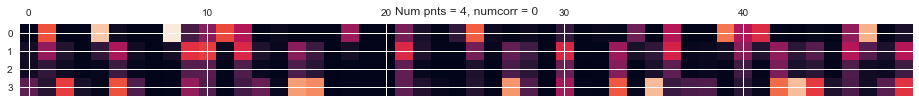

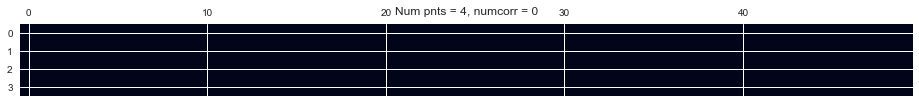

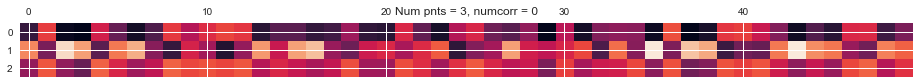

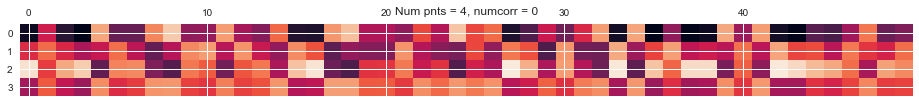

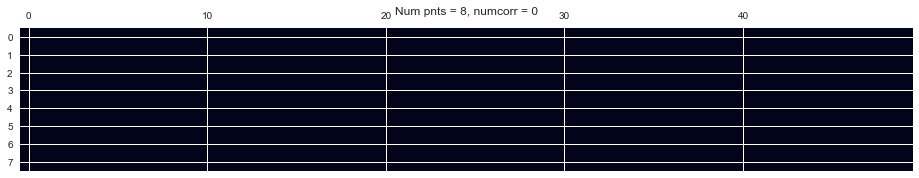

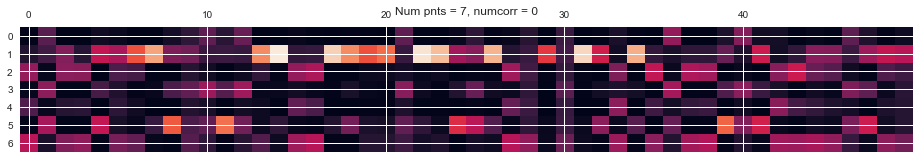

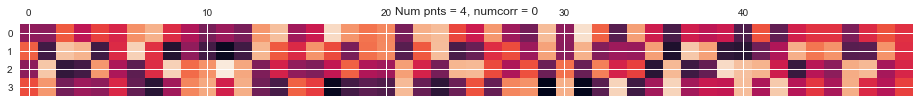

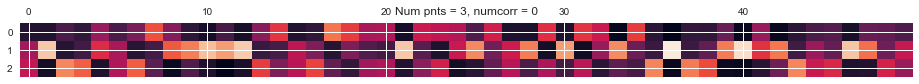

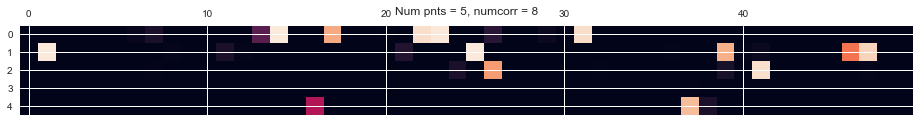

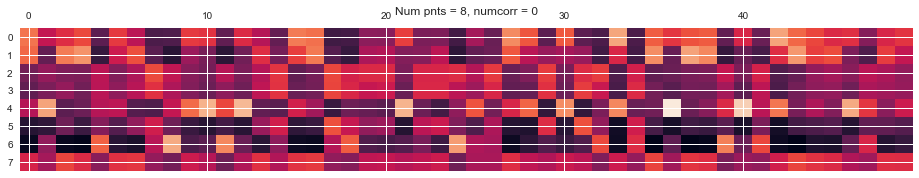

In [17]:
for rr in r:
    plt.matshow(rr.p_old)
    plt.title("Num pnts = {}, numcorr = {}".format(len(rr.TY), (rr.p_old > 0.9).sum()))

Registering the slabs to the long calibration will likely fail in 3D, but we can use the sparsity to our advantage and project into 2D. Does this help?

INFO:pyPALM.registration:Average distance converged
INFO:pyPALM.registration:Objective function converged
INFO:pyPALM.registration:Objective function converged


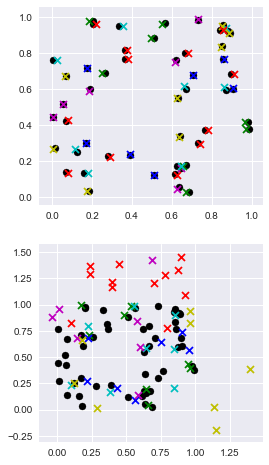

In [18]:
logger.setLevel(logging.INFO)
with np.errstate(invalid="raise"):
    r = main2(ps1[1:], [slab[1:] for slab in slabs_wnoise], weight=0.95, maxiters=10000, tol=1e-6)
# rmse(ps1[:npnts], r[0][:npnts])

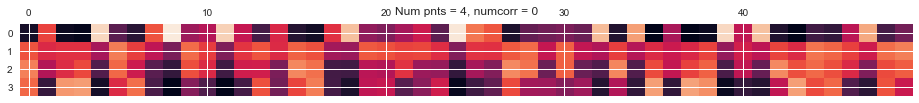

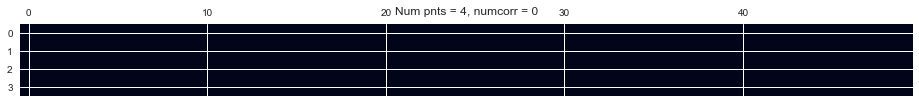

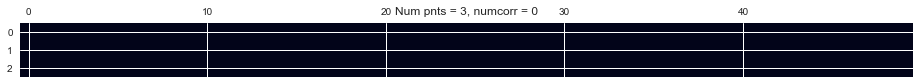

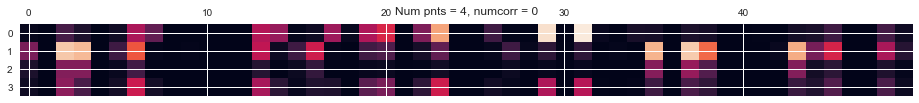

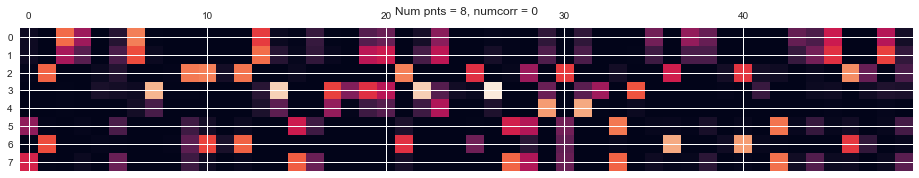

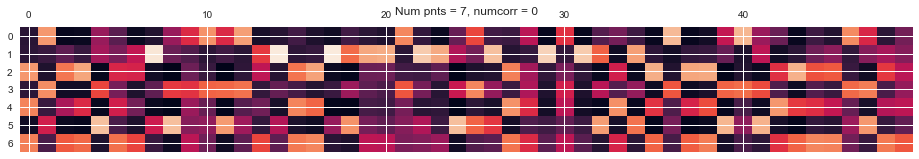

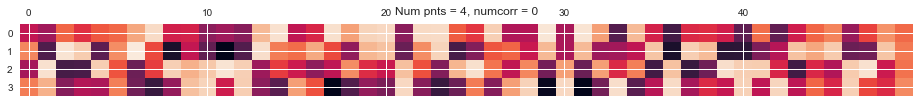

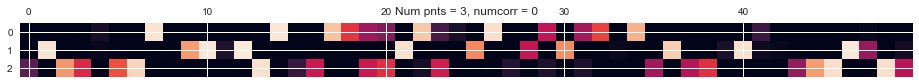

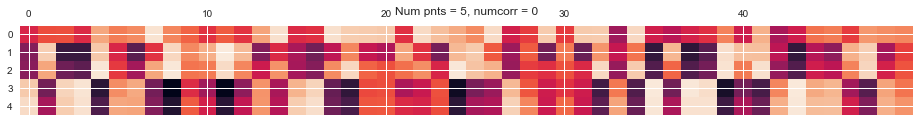

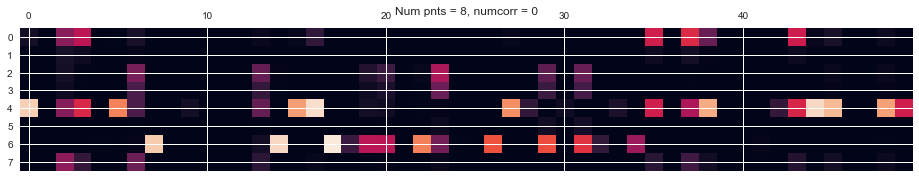

In [19]:
for rr in r:
    plt.matshow(rr.p_old)
    plt.title("Num pnts = {}, numcorr = {}".format(len(rr.TY), (rr.p_old > 0.9).sum()))